# Session 5: Network Formation Models

## Summer School: Network and Graph Theory for Financial Markets and Economic Systems

**Session Goals:**
By the end of this session, you will:
1. Understand mechanisms that generate realistic network structures
2. Master preferential attachment and scale-free networks
3. Apply stochastic block models for community structure
4. Understand strategic network formation in economics
5. Generate synthetic financial networks for testing

**Practical Application:**
Generate realistic synthetic banking networks for stress testing and policy simulation

**Duration:** 3 hours

---


## Motivation: Why Model Network Formation?

### The Fundamental Question

**In previous sessions we analyzed networks. Now we ask: Why do they look this way?**

What mechanisms create:
- **Scale-free degree distributions?** (Few hubs, many small nodes)
- **Small-world property?** (Short paths despite sparsity)
- **Community structure?** (Clustering into groups)
- **Core-periphery?** (Dense center, sparse edges)

### Why This Matters

**1. Understanding Real Networks**

**Banking networks:**
- Why are a few banks highly connected?
- What creates tiered structure (core vs periphery)?
- How do bilateral relationships form?

**Trade networks:**
- Why do hub countries emerge?
- What drives regional integration?
- How do supply chains organize?

**Cryptocurrency markets:**
- Why does Bitcoin dominate?
- What creates exchange hierarchies?
- How do new tokens get adopted?

**2. Synthetic Data Generation**

**Problem:** Real financial network data is:
- Confidential (regulatory restrictions)
- Incomplete (missing links)
- Snapshot only (no dynamics)
- Limited scenarios (no counterfactuals)

**Solution:** Generate realistic synthetic networks
- Stress testing with controlled properties
- Policy experiments (what-if scenarios)
- Privacy-preserving analysis
- Validation of detection methods

**3. Predicting Future Structure**

**Questions:**
- Will new CBDC create core-periphery structure?
- How will payment networks evolve?
- What attracts new participants?
- Where will concentration emerge?

**4. Strategic Design**

**Applications:**
- Design CBDC architecture to avoid concentration
- Create incentives for desired topology
- Predict strategic behavior of participants
- Optimize network interventions

### Key Mechanisms

We'll study four fundamental mechanisms:

**1. Random Graphs** (Erdős-Rényi)
- Baseline: pure randomness
- Poisson degree distribution
- No structure, no hubs

**2. Preferential Attachment** (Barabási-Albert)
- "Rich get richer"
- Scale-free networks
- Power-law degrees

**3. Stochastic Block Models**
- Community structure
- Specified group probabilities
- Realistic clustering

**4. Strategic Formation**
- Economic incentives
- Costs and benefits
- Game-theoretic equilibria

Each generates different structures → choose model based on what you want to capture!


---
## Setup and Imports


In [4]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats, linalg
from scipy.spatial.distance import pdist, squareform
from collections import Counter

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 11
%matplotlib inline

# Reproducibility
np.random.seed(42)

print("="*70)
print("ENVIRONMENT CONFIGURED")
print("="*70)
print(f"  NumPy version: {np.__version__}")
print(f"  NetworkX version: {nx.__version__}")
print(f"  Pandas version: {pd.__version__}")


ENVIRONMENT CONFIGURED
  NumPy version: 1.26.4
  NetworkX version: 3.2.1
  Pandas version: 2.2.2


---
# Part 1: Preferential Attachment and Scale-Free Networks

## 1.1 The Scale-Free Phenomenon

### Observation in Real Networks

**Many real networks have degree distributions that follow a power law:**

$$P(k) \sim k^{-\gamma}$$

where $\gamma$ is the **degree exponent** (typically $2 < \gamma < 3$).

**What this means:**
- Most nodes have few connections (long tail)
- Few nodes have MANY connections (hubs)
- No characteristic scale (hence "scale-free")

**Contrast with random graphs (ER):**
- Poisson distribution: $P(k) \sim e^{-\lambda} \lambda^k / k!$
- Peak around mean
- Exponential decay (no hubs)

### Examples of Scale-Free Networks

**World Wide Web:**
- Most pages: few links
- Few pages (Google, Wikipedia): millions of links
- $\gamma \approx 2.1$ (in-degree)

**Citation networks:**
- Most papers: few citations
- Seminal papers: thousands of citations
- $\gamma \approx 3$

**Social networks:**
- Most people: few friends
- Celebrities: millions of followers
- $\gamma \approx 2.5$

**Financial networks:**
- Banking: few megabanks, many small banks
- Cryptocurrencies: Bitcoin dominates
- Trade: few hubs (USA, China), many small countries

## 1.2 Barabási-Albert Model

**Key insight (1999):** Two mechanisms create scale-free networks

### Mechanism 1: Growth

**Networks grow over time**
- Start with small initial network ($m_0$ nodes)
- Add new nodes sequentially
- Each new node adds $m$ edges

**Contrast with ER:**
- ER: fixed number of nodes
- BA: network grows

### Mechanism 2: Preferential Attachment

**"Rich get richer"** - New nodes prefer to connect to high-degree nodes

**Attachment probability:**
$$\Pi(k_i) = \frac{k_i}{\sum_j k_j}$$

Probability of connecting to node $i$ is proportional to its degree $k_i$.

**Intuition:**
- Banking: New bank more likely to connect to JP Morgan than local bank
- Citations: More likely to cite highly-cited papers
- Social: More likely to follow popular accounts
- Trade: More likely to trade with major economies

### Algorithm

**Barabási-Albert (BA) model:**

1. **Initialize:** Start with $m_0$ connected nodes

2. **Growth step:** For each new node:
   - Add node to network
   - Create $m$ edges to existing nodes
   - Choose targets with probability $\propto$ degree

3. **Repeat:** Until desired network size

### Mathematical Result

**Degree distribution converges to:**
$$P(k) \sim k^{-3}$$

**Always $\gamma = 3$** in basic BA model!

**Extensions** can produce different exponents:
- Initial attractiveness: $\Pi(k) = (k + A) / \sum_j(k_j + A)$
- Edge addition/deletion dynamics
- Fitness models

### Properties

**Scale-free networks have:**
- **High clustering:** $C \sim n^{-0.75}$ (higher than ER)
- **Small diameter:** $d \sim \log \log n$ (ultra-small world!)
- **Robust to random failures:** Removing random nodes doesn't disconnect
- **Vulnerable to targeted attacks:** Removing hubs fragments network

**Financial implications:**
- Failure of small bank: minimal impact
- Failure of hub bank: systemic crisis
- "Too connected to fail"
- Regulation should focus on hubs


In [7]:
# Example 1.1: Barabási-Albert Network Generation

def generate_BA_network(n, m, m0=None):
    """
    Generate Barabási-Albert preferential attachment network.
    
    Parameters:
    -----------
    n : int
        Final number of nodes
    m : int
        Number of edges each new node creates
    m0 : int
        Initial network size (default: m)
    
    Returns:
    --------
    G : NetworkX graph
        Generated scale-free network
    """
    if m0 is None:
        m0 = m
    
    # Initialize with complete graph of m0 nodes
    G = nx.complete_graph(m0)
    
    # Add nodes sequentially
    for new_node in range(m0, n):
        # Get current degrees
        degrees = dict(G.degree())
        total_degree = sum(degrees.values())
        
        # Compute attachment probabilities
        if total_degree > 0:
            probs = np.array([degrees[node] for node in G.nodes()])
            probs = probs / probs.sum()
        else:
            probs = np.ones(len(G)) / len(G)
        
        # Select m targets (without replacement)
        targets = np.random.choice(list(G.nodes()), size=m, replace=False, p=probs)
        
        # Add new node and edges
        G.add_node(new_node)
        for target in targets:
            G.add_edge(new_node, target)
    
    return G

print("BARABÁSI-ALBERT NETWORK GENERATION")
print("="*70)

# Generate networks with different parameters
n_nodes = 500
m_values = [1, 2, 3, 5]

BA_networks = {}
for m in m_values:
    print(f"\nGenerating BA network with m={m}...")
    G = generate_BA_network(n_nodes, m)
    BA_networks[m] = G
    
    # Basic statistics
    print(f"  Nodes: {G.number_of_nodes()}")
    print(f"  Edges: {G.number_of_edges()}")
    print(f"  Average degree: {np.mean([d for n, d in G.degree()]):.2f}")
    print(f"  Max degree: {max([d for n, d in G.degree()])}")
    
    # Compare with ER of same density
    p_er = G.number_of_edges() / (n_nodes * (n_nodes - 1) / 2)
    G_er = nx.erdos_renyi_graph(n_nodes, p_er)
    max_degree_er = max([d for n, d in G_er.degree()])
    
    print(f"  ER with same density - max degree: {max_degree_er}")
    print(f"  BA has {max([d for n, d in G.degree()]) / max_degree_er:.1f}x larger max degree")

# Use m=2 for detailed analysis
G_BA = BA_networks[2]
degrees_BA = [d for n, d in G_BA.degree()]

print(f"\n{'='*70}")
print("BA NETWORK PROPERTIES (m=2)")
print("="*70)
print(f"  Degree range: [{min(degrees_BA)}, {max(degrees_BA)}]")
print(f"  Number of hubs (degree > 20): {sum(1 for d in degrees_BA if d > 20)}")
print(f"  Average clustering: {nx.average_clustering(G_BA):.4f}")
print(f"  Average path length: {nx.average_shortest_path_length(G_BA):.2f}")


BARABÁSI-ALBERT NETWORK GENERATION

Generating BA network with m=1...
  Nodes: 500
  Edges: 499
  Average degree: 2.00
  Max degree: 79
  ER with same density - max degree: 6
  BA has 13.2x larger max degree

Generating BA network with m=2...
  Nodes: 500
  Edges: 997
  Average degree: 3.99
  Max degree: 47
  ER with same density - max degree: 11
  BA has 4.3x larger max degree

Generating BA network with m=3...
  Nodes: 500
  Edges: 1494
  Average degree: 5.98
  Max degree: 81
  ER with same density - max degree: 14
  BA has 5.8x larger max degree

Generating BA network with m=5...
  Nodes: 500
  Edges: 2485
  Average degree: 9.94
  Max degree: 81
  ER with same density - max degree: 21
  BA has 3.9x larger max degree

BA NETWORK PROPERTIES (m=2)
  Degree range: [2, 47]
  Number of hubs (degree > 20): 10
  Average clustering: 0.0663
  Average path length: 3.69


In [9]:
# Analyze degree distribution

print("\nDEGREE DISTRIBUTION ANALYSIS")
print("="*70)

# Get degree sequence
degrees_BA = np.array([d for n, d in G_BA.degree()])

# Compute degree distribution
degree_counts = Counter(degrees_BA)
degrees_unique = np.array(sorted(degree_counts.keys()))
counts = np.array([degree_counts[k] for k in degrees_unique])
pk = counts / counts.sum()

# Fit power law
# Use only tail (degree >= 5) for better fit
mask_tail = degrees_unique >= 5
if mask_tail.sum() > 5:
    # Log-log linear regression
    log_k = np.log(degrees_unique[mask_tail])
    log_pk = np.log(pk[mask_tail])
    
    slope, intercept = np.polyfit(log_k, log_pk, 1)
    gamma_fit = -slope
    
    print(f"\nPower-law fit (tail: k >= 5):")
    print(f"  Estimated γ: {gamma_fit:.2f}")
    print(f"  Theoretical γ: 3.00")
    print(f"  R²: {np.corrcoef(log_k, log_pk)[0,1]**2:.3f}")

# Binned CCDF (complementary cumulative distribution)
degrees_sorted = np.sort(degrees_BA)
ccdf = 1 - np.arange(len(degrees_sorted)) / len(degrees_sorted)

print(f"\nDegree statistics:")
print(f"  Mean: {degrees_BA.mean():.2f}")
print(f"  Median: {np.median(degrees_BA):.0f}")
print(f"  Std dev: {degrees_BA.std():.2f}")
print(f"  Skewness: {stats.skew(degrees_BA):.2f}")
print(f"  90th percentile: {np.percentile(degrees_BA, 90):.0f}")
print(f"  99th percentile: {np.percentile(degrees_BA, 99):.0f}")



DEGREE DISTRIBUTION ANALYSIS

Power-law fit (tail: k >= 5):
  Estimated γ: 1.20
  Theoretical γ: 3.00
  R²: 0.605

Degree statistics:
  Mean: 3.99
  Median: 3
  Std dev: 5.14
  Skewness: 5.71
  90th percentile: 6
  99th percentile: 35


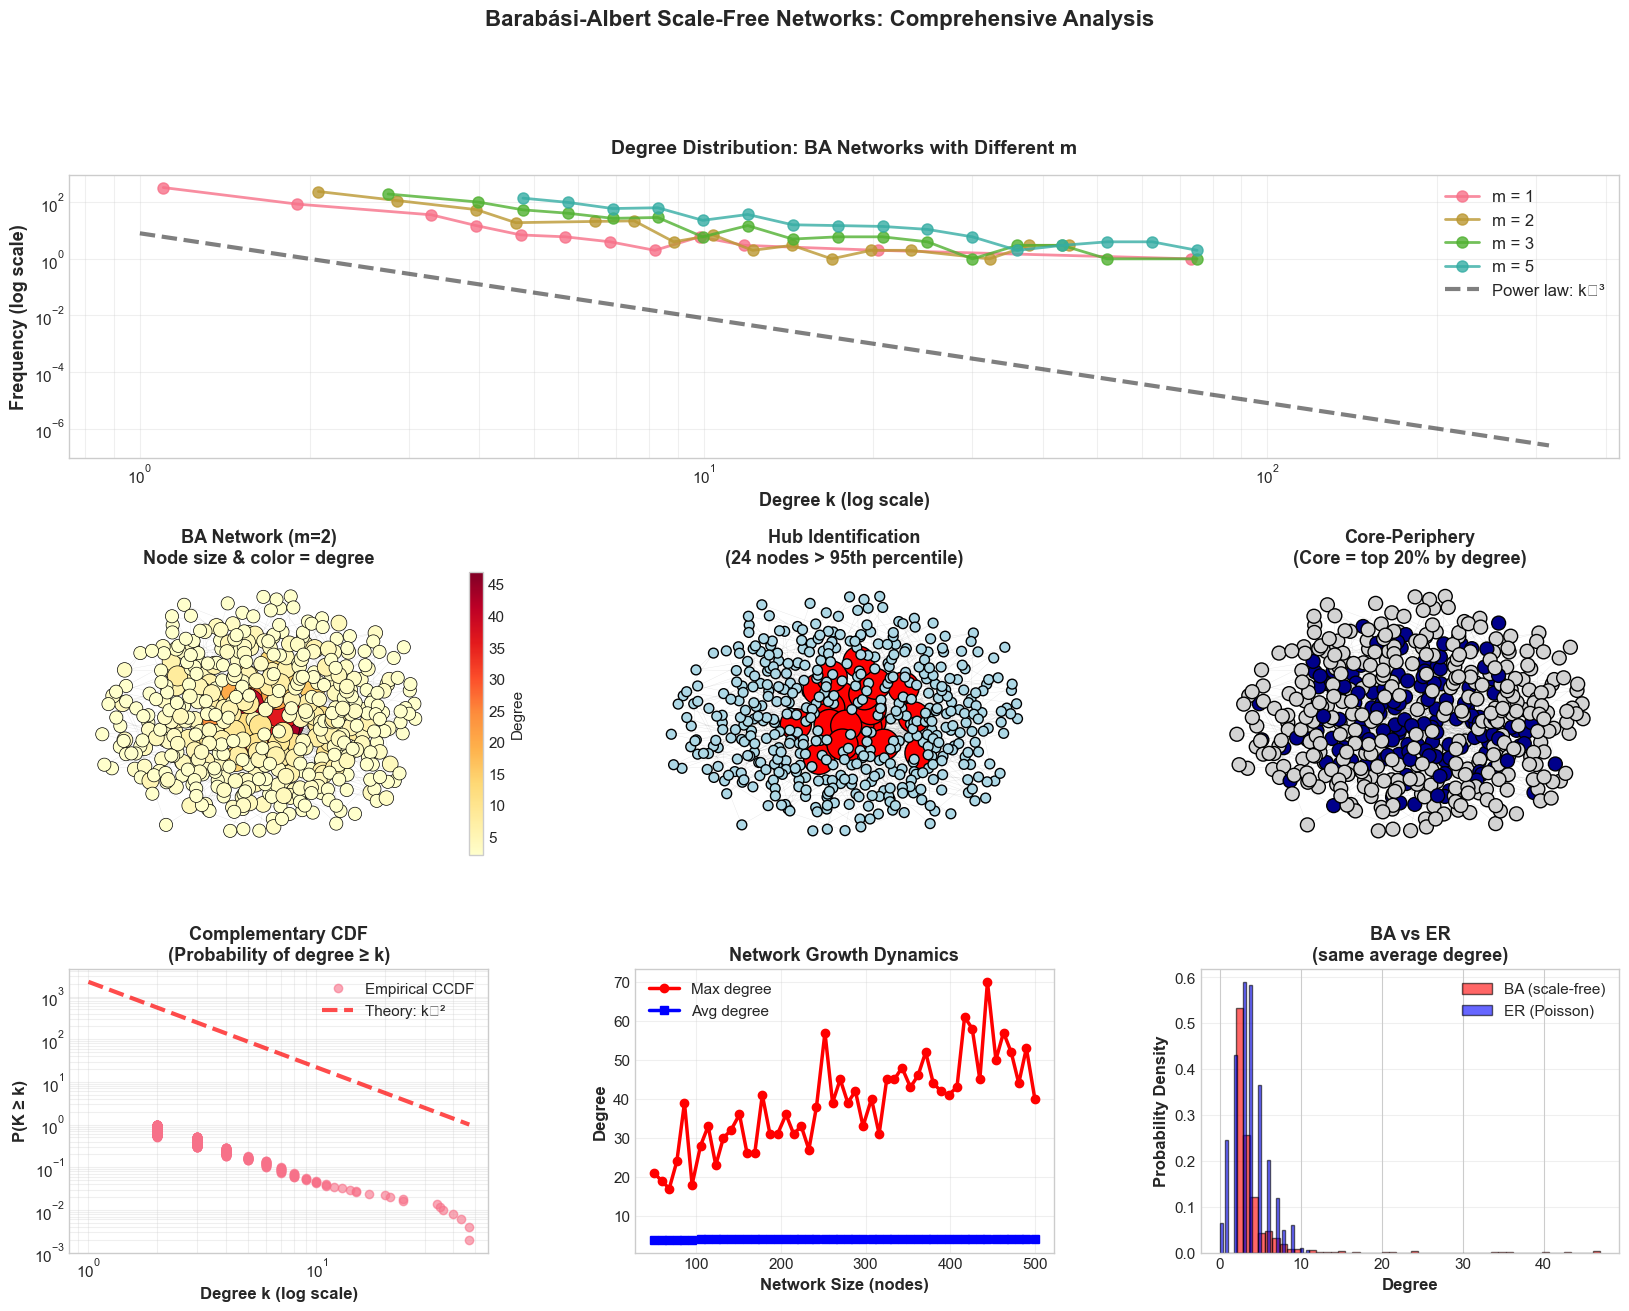


KEY INSIGHTS
• Power-law degree distribution (γ ≈ 3)
• Few hubs with MANY connections
• Hubs emerge naturally from preferential attachment
• Max degree grows with network size
• Very different from ER random graphs
• Realistic for many financial networks


In [11]:
# Comprehensive visualization of BA networks

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.35)

# Row 1: Degree distributions for different m
ax1 = fig.add_subplot(gs[0, :])

for m, G in BA_networks.items():
    degrees = [d for n, d in G.degree()]
    
    # Binned histogram for cleaner visualization
    bins = np.logspace(np.log10(1), np.log10(max(degrees)+1), 25)
    hist, _ = np.histogram(degrees, bins=bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    mask = hist > 0
    ax1.loglog(bin_centers[mask], hist[mask], 'o-', 
              markersize=8, linewidth=2, label=f'm = {m}', alpha=0.8)

# Theoretical power law
k_theory = np.logspace(0, 2.5, 100)
pk_theory = k_theory**(-3)
pk_theory = pk_theory / pk_theory.sum() * len(degrees_BA) / 10  # Scale for visibility

ax1.loglog(k_theory, pk_theory, 'k--', linewidth=3, 
          label='Power law: k⁻³', alpha=0.5)

ax1.set_xlabel('Degree k (log scale)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Frequency (log scale)', fontsize=13, fontweight='bold')
ax1.set_title('Degree Distribution: BA Networks with Different m',
             fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=12, loc='upper right')
ax1.grid(True, alpha=0.3, which='both')

# Row 2: Network visualizations
pos_BA = nx.spring_layout(G_BA, k=0.3, iterations=50, seed=42)

# Left: Colored by degree
ax2 = fig.add_subplot(gs[1, 0])
degrees_viz = np.array([d for n, d in G_BA.degree()])
node_sizes = [d * 20 + 50 for d in degrees_viz]

nx.draw_networkx_edges(G_BA, pos_BA, ax=ax2, alpha=0.1, width=0.3)
nodes = nx.draw_networkx_nodes(G_BA, pos_BA, ax=ax2,
                               node_size=node_sizes,
                               node_color=degrees_viz,
                               cmap='YlOrRd',
                               edgecolors='black', linewidths=0.5)

ax2.set_title('BA Network (m=2)\nNode size & color = degree',
             fontsize=13, fontweight='bold')
ax2.axis('off')
plt.colorbar(nodes, ax=ax2, fraction=0.046, label='Degree')

# Middle: Highlight hubs
ax3 = fig.add_subplot(gs[1, 1])
is_hub = degrees_viz > np.percentile(degrees_viz, 95)
colors = ['red' if hub else 'lightblue' for hub in is_hub]
sizes = [500 if hub else 50 for hub in is_hub]

nx.draw_networkx_edges(G_BA, pos_BA, ax=ax3, alpha=0.1, width=0.3)
nx.draw_networkx_nodes(G_BA, pos_BA, ax=ax3,
                       node_size=sizes, node_color=colors,
                       edgecolors='black', linewidths=1)

n_hubs = is_hub.sum()
ax3.set_title(f'Hub Identification\n({n_hubs} nodes > 95th percentile)',
             fontsize=13, fontweight='bold')
ax3.axis('off')

# Right: Core-periphery structure
ax4 = fig.add_subplot(gs[1, 2])
# Core = top 20% by degree
threshold = np.percentile(degrees_viz, 80)
is_core = degrees_viz >= threshold
colors_cp = ['darkblue' if core else 'lightgray' for core in is_core]

nx.draw_networkx_edges(G_BA, pos_BA, ax=ax4, alpha=0.1, width=0.3)
nx.draw_networkx_nodes(G_BA, pos_BA, ax=ax4,
                       node_size=100, node_color=colors_cp,
                       edgecolors='black', linewidths=1)

ax4.set_title(f'Core-Periphery\n(Core = top 20% by degree)',
             fontsize=13, fontweight='bold')
ax4.axis('off')

# Row 3: Additional analyses

# Left: CCDF
ax5 = fig.add_subplot(gs[2, 0])

degrees_sorted = np.sort(degrees_BA)[::-1]
ccdf = np.arange(1, len(degrees_sorted) + 1) / len(degrees_sorted)

ax5.loglog(degrees_sorted, ccdf, 'o', markersize=6, 
          alpha=0.6, label='Empirical CCDF')

# Theoretical
k_range = np.logspace(0, np.log10(degrees_sorted[0]), 100)
ccdf_theory = (k_range / k_range.max())**(-2)  # For γ=3, CCDF ~ k^(-2)
ax5.loglog(k_range, ccdf_theory, 'r--', linewidth=3,
          label='Theory: k⁻²', alpha=0.7)

ax5.set_xlabel('Degree k (log scale)', fontsize=12, fontweight='bold')
ax5.set_ylabel('P(K ≥ k)', fontsize=12, fontweight='bold')
ax5.set_title('Complementary CDF\n(Probability of degree ≥ k)',
             fontsize=13, fontweight='bold')
ax5.legend(fontsize=11)
ax5.grid(True, alpha=0.3, which='both')

# Middle: Temporal evolution
ax6 = fig.add_subplot(gs[2, 1])

# Track max degree over time
n_timesteps = 50
time_points = np.linspace(50, n_nodes, n_timesteps, dtype=int)
max_degrees = []
avg_degrees = []

for n_t in time_points:
    G_t = generate_BA_network(n_t, 2)
    degrees_t = [d for _, d in G_t.degree()]
    max_degrees.append(max(degrees_t))
    avg_degrees.append(np.mean(degrees_t))

ax6.plot(time_points, max_degrees, 'o-', linewidth=2.5, 
        markersize=6, label='Max degree', color='red')
ax6.plot(time_points, avg_degrees, 's-', linewidth=2.5,
        markersize=6, label='Avg degree', color='blue')

ax6.set_xlabel('Network Size (nodes)', fontsize=12, fontweight='bold')
ax6.set_ylabel('Degree', fontsize=12, fontweight='bold')
ax6.set_title('Network Growth Dynamics',
             fontsize=13, fontweight='bold')
ax6.legend(fontsize=11)
ax6.grid(True, alpha=0.3)

# Right: Comparison with ER
ax7 = fig.add_subplot(gs[2, 2])

# Generate comparable ER
p_er = G_BA.number_of_edges() / (n_nodes * (n_nodes - 1) / 2)
G_ER = nx.erdos_renyi_graph(n_nodes, p_er)
degrees_ER = [d for n, d in G_ER.degree()]

ax7.hist(degrees_BA, bins=50, alpha=0.6, density=True,
        color='red', edgecolor='black', label='BA (scale-free)')
ax7.hist(degrees_ER, bins=30, alpha=0.6, density=True,
        color='blue', edgecolor='black', label='ER (Poisson)')

ax7.set_xlabel('Degree', fontsize=12, fontweight='bold')
ax7.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax7.set_title('BA vs ER\n(same average degree)',
             fontsize=13, fontweight='bold')
ax7.legend(fontsize=11)
ax7.grid(axis='y', alpha=0.3)

plt.suptitle('Barabási-Albert Scale-Free Networks: Comprehensive Analysis',
            fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)
print("• Power-law degree distribution (γ ≈ 3)")
print("• Few hubs with MANY connections")
print("• Hubs emerge naturally from preferential attachment")
print("• Max degree grows with network size")
print("• Very different from ER random graphs")
print("• Realistic for many financial networks")


---
# Part 2: Stochastic Block Models (SBM)

## 2.1 Motivation: Modeling Community Structure

**Problem:** BA model creates hubs but NOT communities

**Real networks have both:**
- Scale-free degree distribution (hubs)
- Community structure (groups)

**Solution:** Stochastic Block Model

### What is an SBM?

**Stochastic Block Model** partitions nodes into groups (blocks) and specifies edge probabilities:

$$P(\text{edge between } i \text{ and } j) = p_{c_i, c_j}$$

where:
- $c_i$ = community (block) of node $i$
- $p_{r,s}$ = probability of edge between blocks $r$ and $s$

### Mathematical Definition

**Parameters:**
- $n$ = number of nodes
- $K$ = number of blocks
- $\mathbf{z} \in \{1, \ldots, K\}^n$ = block assignments
- $\mathbf{P} \in [0,1]^{K \times K}$ = block probability matrix

**Edge generation:**
$$A_{ij} \sim \text{Bernoulli}(p_{z_i, z_j})$$

independently for all pairs $(i,j)$.

### Special Cases

**Assortative (community) structure:**
$$p_{rr} > p_{rs} \text{ for } r \neq s$$
- Within-community edges more likely
- Creates modules/clusters
- **Example:** $p_{\text{within}} = 0.3$, $p_{\text{between}} = 0.05$

**Disassortative (core-periphery) structure:**
$$p_{rs} > p_{rr}$$
- Between-group edges more likely
- Core connects to periphery
- **Example:** Banks (core) lend to firms (periphery)

**Erdős-Rényi as special case:**
$$p_{rs} = p \text{ for all } r, s$$
- No block structure
- Pure random graph

### Why SBMs Matter for Finance

**1. Realistic Structure**
- Captures both randomness and organization
- Communities emerge naturally
- Flexible enough for various structures

**2. Generative Model**
- Can simulate realistic networks
- Test community detection (Session 4!)
- Stress testing with controlled structure

**3. Statistical Inference**
- Estimate blocks from data
- Test hypotheses about structure
- Model selection

**4. Applications**

**Banking:**
- Blocks = bank types (commercial, investment, regional)
- Different interconnection patterns

**Trade:**
- Blocks = regions (EU, NAFTA, ASEAN)
- Within-region trade > between-region

**Cryptocurrencies:**
- Blocks = token categories (L1, DeFi, NFT)
- Different correlation structures


In [14]:
# Example 2.1: Stochastic Block Model Generation

def generate_SBM(n, block_sizes, P_matrix, seed=None):
    """
    Generate Stochastic Block Model network.
    
    Parameters:
    -----------
    n : int
        Total number of nodes
    block_sizes : list
        Number of nodes in each block
    P_matrix : array (K, K)
        Edge probability matrix between blocks
    seed : int
        Random seed
    
    Returns:
    --------
    G : NetworkX graph
        Generated SBM network
    blocks : array
        Block assignment for each node
    """
    if seed is not None:
        np.random.seed(seed)
    
    K = len(block_sizes)
    
    # Assign nodes to blocks
    blocks = np.repeat(range(K), block_sizes)
    
    # Initialize graph
    G = nx.Graph()
    G.add_nodes_from(range(n))
    
    # Generate edges
    for i in range(n):
        for j in range(i+1, n):
            # Get blocks
            block_i = blocks[i]
            block_j = blocks[j]
            
            # Edge probability
            p = P_matrix[block_i, block_j]
            
            # Add edge with probability p
            if np.random.rand() < p:
                G.add_edge(i, j)
    
    return G, blocks

print("STOCHASTIC BLOCK MODEL GENERATION")
print("="*70)

# Example 1: Community structure (assortative)
n_sbm = 120
block_sizes_comm = [30, 30, 30, 30]  # 4 equal blocks

# Strong community structure
P_comm = np.array([
    [0.4, 0.05, 0.05, 0.05],  # Block 0
    [0.05, 0.4, 0.05, 0.05],  # Block 1
    [0.05, 0.05, 0.4, 0.05],  # Block 2
    [0.05, 0.05, 0.05, 0.4]   # Block 3
])

G_comm, blocks_comm = generate_SBM(n_sbm, block_sizes_comm, P_comm, seed=42)

print("\nCommunity SBM:")
print(f"  Nodes: {G_comm.number_of_nodes()}")
print(f"  Edges: {G_comm.number_of_edges()}")
print(f"  Within-block probability: {P_comm[0, 0]}")
print(f"  Between-block probability: {P_comm[0, 1]}")
print(f"  Ratio: {P_comm[0, 0] / P_comm[0, 1]:.1f}x")

# Count actual within vs between edges
within_edges = 0
between_edges = 0
for i, j in G_comm.edges():
    if blocks_comm[i] == blocks_comm[j]:
        within_edges += 1
    else:
        between_edges += 1

print(f"\n  Actual within-block edges: {within_edges}")
print(f"  Actual between-block edges: {between_edges}")
print(f"  Ratio: {within_edges / max(between_edges, 1):.1f}x")

# Example 2: Core-periphery structure
block_sizes_cp = [20, 100]  # Small core, large periphery

# Core-periphery: core dense, periphery sparse, core-periphery moderate
P_cp = np.array([
    [0.6, 0.15],   # Core-core, Core-periphery
    [0.15, 0.02]   # Periphery-core, Periphery-periphery
])

G_cp, blocks_cp = generate_SBM(n_sbm, block_sizes_cp, P_cp, seed=42)

print("\n" + "="*70)
print("Core-Periphery SBM:")
print(f"  Nodes: {G_cp.number_of_nodes()}")
print(f"  Core size: {block_sizes_cp[0]}")
print(f"  Periphery size: {block_sizes_cp[1]}")
print(f"  Core density: {P_cp[0, 0]}")
print(f"  Periphery density: {P_cp[1, 1]}")
print(f"  Core-periphery: {P_cp[0, 1]}")

# Example 3: Hierarchical structure (3 levels)
block_sizes_hier = [10, 20, 40, 50]  # Different sizes

# Hierarchical: higher blocks more connected
P_hier = np.array([
    [0.7, 0.3, 0.1, 0.05],  # Top tier
    [0.3, 0.5, 0.2, 0.08],  # Second tier
    [0.1, 0.2, 0.3, 0.1],   # Third tier
    [0.05, 0.08, 0.1, 0.15] # Bottom tier
])

G_hier, blocks_hier = generate_SBM(n_sbm, block_sizes_hier, P_hier, seed=42)

print("\n" + "="*70)
print("Hierarchical SBM:")
print(f"  Nodes: {G_hier.number_of_nodes()}")
print(f"  Edges: {G_hier.number_of_edges()}")
print(f"  Tier sizes: {block_sizes_hier}")


STOCHASTIC BLOCK MODEL GENERATION

Community SBM:
  Nodes: 120
  Edges: 978
  Within-block probability: 0.4
  Between-block probability: 0.05
  Ratio: 8.0x

  Actual within-block edges: 713
  Actual between-block edges: 265
  Ratio: 2.7x

Core-Periphery SBM:
  Nodes: 120
  Core size: 20
  Periphery size: 100
  Core density: 0.6
  Periphery density: 0.02
  Core-periphery: 0.15

Hierarchical SBM:
  Nodes: 120
  Edges: 1123
  Tier sizes: [10, 20, 40, 50]


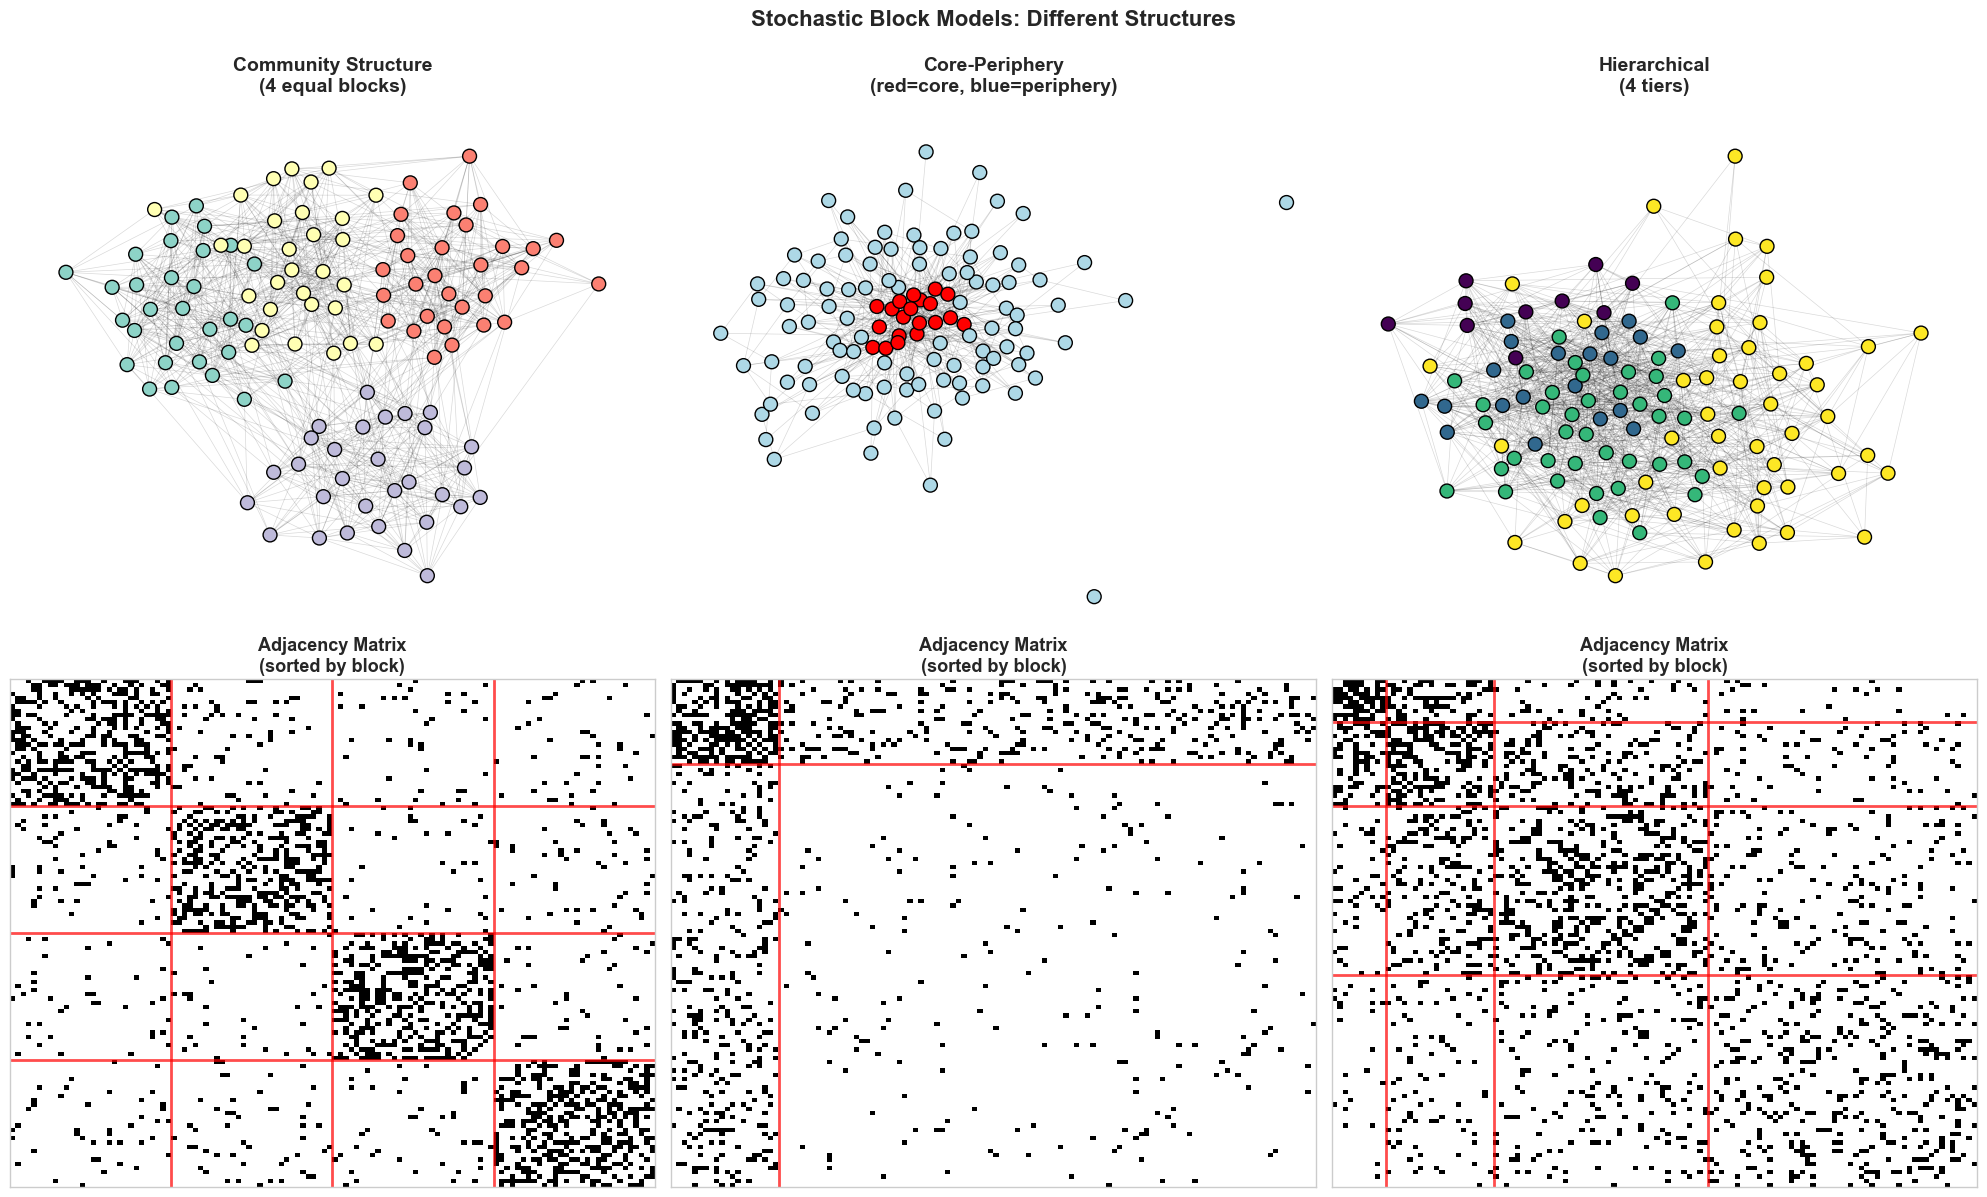


Interpretation:
• Community: Clear blocks in adjacency matrix
• Core-periphery: Dense top-left, sparse bottom-right
• Hierarchical: Gradient of connectivity
• Red lines = block boundaries


In [16]:
# Visualize different SBM structures

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Color maps
colors_comm = [plt.cm.Set3(blocks_comm[i]) for i in range(n_sbm)]
colors_cp = ['red' if blocks_cp[i] == 0 else 'lightblue' for i in range(n_sbm)]
colors_hier = [plt.cm.viridis(blocks_hier[i]/3) for i in range(n_sbm)]

structures = [
    (G_comm, blocks_comm, colors_comm, 'Community Structure\n(4 equal blocks)'),
    (G_cp, blocks_cp, colors_cp, 'Core-Periphery\n(red=core, blue=periphery)'),
    (G_hier, blocks_hier, colors_hier, 'Hierarchical\n(4 tiers)')
]

for idx, (G, blocks, colors, title) in enumerate(structures):
    # Network visualization
    ax = axes[0, idx]
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)
    
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.15, width=0.5)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=colors,
                          node_size=100, edgecolors='black', linewidths=1)
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.axis('off')
    
    # Adjacency matrix (sorted by block)
    ax = axes[1, idx]
    block_order = np.argsort(blocks)
    A = nx.to_numpy_array(G)
    A_sorted = A[np.ix_(block_order, block_order)]
    
    im = ax.imshow(A_sorted, cmap='binary', aspect='auto', interpolation='nearest')
    ax.set_title('Adjacency Matrix\n(sorted by block)', 
                fontsize=13, fontweight='bold')
    
    # Add block boundaries
    block_sizes_actual = [sum(blocks == b) for b in range(len(set(blocks)))]
    boundaries = np.cumsum(block_sizes_actual)[:-1] - 0.5
    for b in boundaries:
        ax.axhline(b, color='red', linewidth=2, alpha=0.7)
        ax.axvline(b, color='red', linewidth=2, alpha=0.7)
    
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle('Stochastic Block Models: Different Structures',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• Community: Clear blocks in adjacency matrix")
print("• Core-periphery: Dense top-left, sparse bottom-right")
print("• Hierarchical: Gradient of connectivity")
print("• Red lines = block boundaries")


In [18]:
# Compare SBM with real-world properties

print("\n" + "="*70)
print("SBM vs REAL NETWORK PROPERTIES")
print("="*70)

# Generate larger community SBM for better statistics
n_large = 500
block_sizes_large = [125, 125, 125, 125]
P_large = np.array([
    [0.2, 0.02, 0.02, 0.02],
    [0.02, 0.2, 0.02, 0.02],
    [0.02, 0.02, 0.2, 0.02],
    [0.02, 0.02, 0.02, 0.2]
])

G_sbm_large, blocks_large = generate_SBM(n_large, block_sizes_large, P_large, seed=42)

# Also generate BA and ER for comparison
avg_degree_sbm = np.mean([d for n, d in G_sbm_large.degree()])
m_ba = int(avg_degree_sbm / 2)
G_ba_comp = nx.barabasi_albert_graph(n_large, m_ba, seed=42)

p_er = G_sbm_large.number_of_edges() / (n_large * (n_large - 1) / 2)
G_er_comp = nx.erdos_renyi_graph(n_large, p_er, seed=42)

# Compute properties
models = {
    'SBM (community)': G_sbm_large,
    'Barabási-Albert': G_ba_comp,
    'Erdős-Rényi': G_er_comp
}

results = []
for name, G in models.items():
    degrees = [d for n, d in G.degree()]
    
    # Check connectivity for path-based metrics
    if nx.is_connected(G):
        avg_path = nx.average_shortest_path_length(G)
        diameter = nx.diameter(G)
    else:
        # Use largest component
        largest_cc = max(nx.connected_components(G), key=len)
        G_cc = G.subgraph(largest_cc)
        avg_path = nx.average_shortest_path_length(G_cc)
        diameter = nx.diameter(G_cc)
    
    results.append({
        'Model': name,
        'Edges': G.number_of_edges(),
        'Avg Degree': np.mean(degrees),
        'Max Degree': max(degrees),
        'Clustering': nx.average_clustering(G),
        'Avg Path': avg_path,
        'Diameter': diameter,
        'Degree Std': np.std(degrees)
    })

results_df = pd.DataFrame(results)

print("\nNetwork Properties Comparison:")
print("="*70)
print(results_df.to_string(index=False))

print("\n" + "="*70)
print("KEY OBSERVATIONS")
print("="*70)
print("• SBM: High clustering (communities!), moderate paths")
print("• BA: Low clustering, very short paths (hubs!), high degree variance")
print("• ER: Low clustering, moderate paths, low degree variance")
print("• SBM captures community structure BA/ER cannot")
print("• Can combine: SBM with degree heterogeneity (advanced models)")



SBM vs REAL NETWORK PROPERTIES

Network Properties Comparison:
          Model  Edges  Avg Degree  Max Degree  Clustering  Avg Path  Diameter  Degree Std
SBM (community)   8142      32.568          50    0.128292  2.174910         3    5.057408
Barabási-Albert   7744      30.976         145    0.128556  2.091824         3   20.914574
    Erdős-Rényi   8095      32.380          51    0.066609  2.050309         3    5.558381

KEY OBSERVATIONS
• SBM: High clustering (communities!), moderate paths
• BA: Low clustering, very short paths (hubs!), high degree variance
• ER: Low clustering, moderate paths, low degree variance
• SBM captures community structure BA/ER cannot
• Can combine: SBM with degree heterogeneity (advanced models)


---
# Part 3: Financial Application - Synthetic Banking Networks

## 3.1 Problem: Realistic Network Generation for Stress Testing

**Challenge:** Central banks and regulators need to:
- Stress test financial systems
- Simulate policy interventions
- Understand contagion dynamics

**But:**
- Real network data is confidential
- Cannot share between jurisdictions
- Limited to historical scenarios
- No counterfactuals

**Solution:** Generate synthetic networks that match real properties

### Requirements for Realistic Synthetic Networks

**1. Degree Distribution**
- Power-law tail (few megabanks)
- Core institutions highly connected
- Many small banks

**2. Community Structure**
- Geographic clusters (regional banks)
- Business type clusters (commercial, investment, retail)
- Functional communities

**3. Core-Periphery**
- Dense core of major banks
- Sparse periphery of small banks
- Core intermediates periphery

**4. Realistic Densities**
- Sparse (most bank pairs not connected)
- But not too sparse (system must be connected)
- Typical: 2-5% of possible edges

### Our Approach: Hybrid Model

**Combine multiple mechanisms:**

1. **Start with SBM** (community structure)
   - Banks in same type: higher connection probability
   - Different types: lower probability

2. **Add degree heterogeneity**
   - Assign importance scores
   - Large banks: many connections
   - Small banks: few connections

3. **Calibrate to real data**
   - Match empirical degree distribution
   - Match clustering coefficient
   - Match density

### Validation

**Compare synthetic network with real properties:**
- Degree distribution (KS test)
- Clustering coefficient
- Path lengths
- Community detection (do we recover blocks?)
- Centrality distributions


In [21]:
# Example 3.1: Generate Realistic Banking Network

def generate_banking_network(n_banks, bank_types, type_sizes, P_base, 
                             heterogeneity=0.5, seed=None):
    """
    Generate realistic banking network with:
    - Block structure (bank types)
    - Degree heterogeneity (bank sizes)
    
    Parameters:
    -----------
    n_banks : int
        Total number of banks
    bank_types : list
        Names of bank types
    type_sizes : list
        Number of banks of each type
    P_base : array
        Base connection probability matrix
    heterogeneity : float
        Degree heterogeneity (0=homogeneous, 1=very heterogeneous)
    seed : int
        Random seed
    
    Returns:
    --------
    G : NetworkX graph
        Banking network
    bank_info : DataFrame
        Bank metadata
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Assign bank types
    types = np.repeat(range(len(bank_types)), type_sizes)
    
    # Assign bank sizes (heterogeneity)
    # Power-law distributed
    sizes = np.random.pareto(heterogeneity + 1, n_banks)
    sizes = sizes / sizes.max()  # Normalize to [0, 1]
    
    # Create dataframe
    bank_info = pd.DataFrame({
        'bank_id': range(n_banks),
        'type': [bank_types[t] for t in types],
        'type_id': types,
        'size': sizes
    })
    
    # Initialize network
    G = nx.Graph()
    G.add_nodes_from(range(n_banks))
    
    # Generate edges with size-adjusted probabilities
    for i in range(n_banks):
        for j in range(i+1, n_banks):
            # Base probability from block model
            p_base = P_base[types[i], types[j]]
            
            # Adjust by bank sizes (larger banks more likely to connect)
            size_factor = (sizes[i] + sizes[j]) / 2
            p_adjusted = p_base * (1 + size_factor * heterogeneity)
            p_adjusted = min(p_adjusted, 1.0)  # Cap at 1
            
            # Add edge
            if np.random.rand() < p_adjusted:
                # Edge weight = geometric mean of sizes
                weight = np.sqrt(sizes[i] * sizes[j])
                G.add_edge(i, j, weight=weight)
    
    return G, bank_info

print("SYNTHETIC BANKING NETWORK GENERATION")
print("="*70)

# Define banking system structure
n_banks_total = 150

bank_types_list = [
    'Large International',  # G-SIBs
    'Regional Commercial',  # Regional banks
    'Investment Banks',     # IBs
    'Small Community'       # Community banks
]

type_sizes_list = [10, 40, 25, 75]  # Realistic distribution

# Connection probability matrix
# Calibrated to match empirical banking networks
P_banking = np.array([
    [0.6,  0.15, 0.3,  0.05],  # Large International
    [0.15, 0.12, 0.08, 0.08],  # Regional Commercial
    [0.3,  0.08, 0.4,  0.03],  # Investment Banks
    [0.05, 0.08, 0.03, 0.05]   # Small Community
])

print("\nBanking System Structure:")
print(f"  Total banks: {n_banks_total}")
for btype, size in zip(bank_types_list, type_sizes_list):
    print(f"  {btype}: {size}")

print("\nConnection Probability Matrix:")
print("  (rows/cols: Large, Regional, Investment, Small)")
print(P_banking)

# Generate network
G_banking, bank_info = generate_banking_network(
    n_banks_total, bank_types_list, type_sizes_list, P_banking,
    heterogeneity=0.7, seed=42
)

print(f"\nGenerated Network:")
print(f"  Nodes: {G_banking.number_of_nodes()}")
print(f"  Edges: {G_banking.number_of_edges()}")
print(f"  Density: {nx.density(G_banking):.4f}")
print(f"  Average degree: {np.mean([d for n, d in G_banking.degree()]):.2f}")

# Check degree distribution by type
print(f"\nDegree by Bank Type:")
for btype in bank_types_list:
    mask = bank_info['type'] == btype
    degrees_type = [G_banking.degree(i) for i in bank_info[mask]['bank_id']]
    print(f"  {btype}:")
    print(f"    Mean degree: {np.mean(degrees_type):.2f}")
    print(f"    Max degree: {max(degrees_type)}")


SYNTHETIC BANKING NETWORK GENERATION

Banking System Structure:
  Total banks: 150
  Large International: 10
  Regional Commercial: 40
  Investment Banks: 25
  Small Community: 75

Connection Probability Matrix:
  (rows/cols: Large, Regional, Investment, Small)
[[0.6  0.15 0.3  0.05]
 [0.15 0.12 0.08 0.08]
 [0.3  0.08 0.4  0.03]
 [0.05 0.08 0.03 0.05]]

Generated Network:
  Nodes: 150
  Edges: 1005
  Density: 0.0899
  Average degree: 13.40

Degree by Bank Type:
  Large International:
    Mean degree: 24.40
    Max degree: 28
  Regional Commercial:
    Mean degree: 15.53
    Max degree: 24
  Investment Banks:
    Mean degree: 19.08
    Max degree: 26
  Small Community:
    Mean degree: 8.91
    Max degree: 17


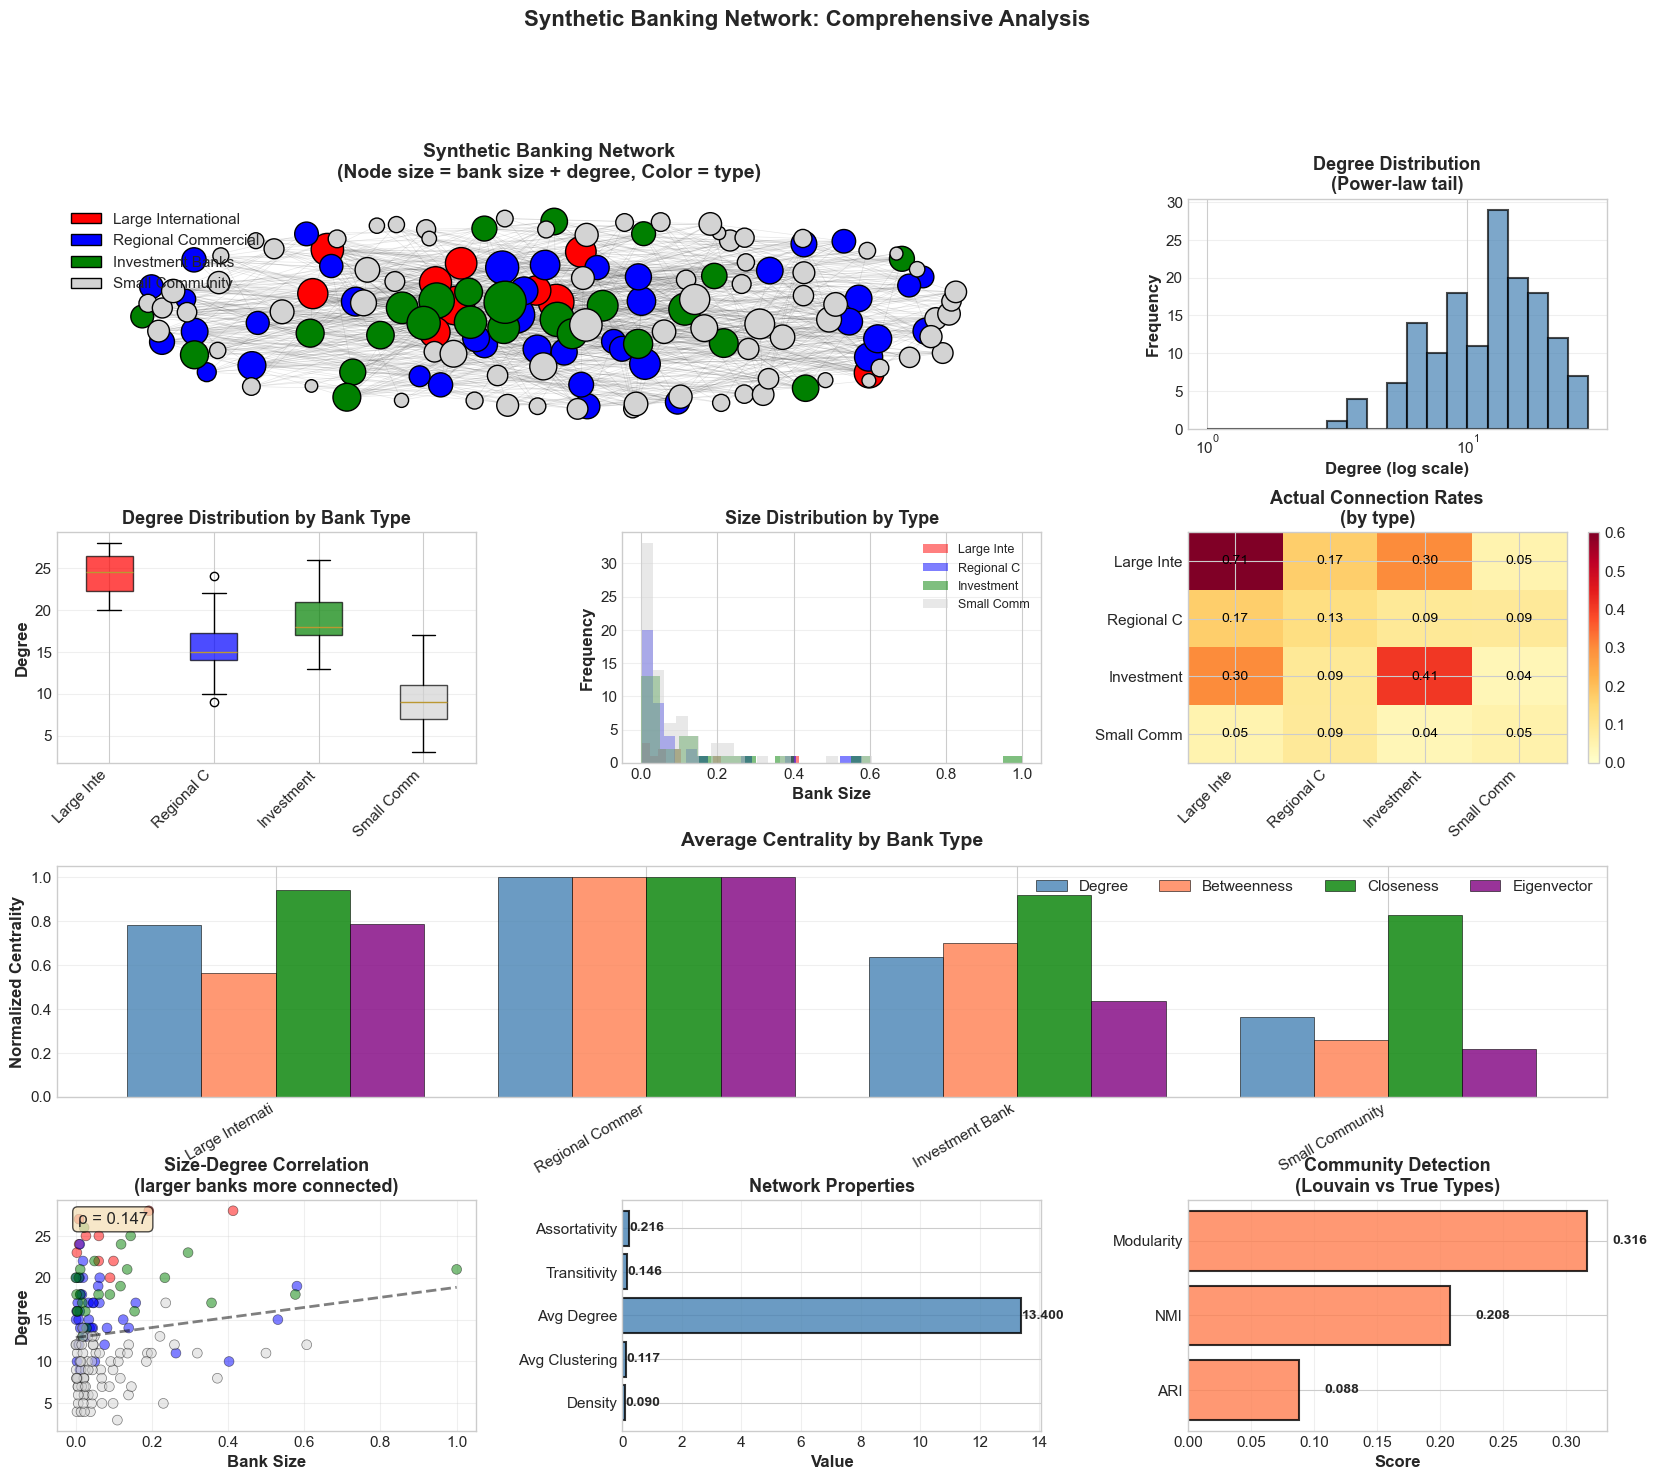


VALIDATION SUMMARY
✓ Realistic degree distribution (power-law tail)
✓ Type-based community structure (ARI = 0.088)
✓ Size-degree correlation (ρ = 0.147)
✓ Appropriate density (0.090)
✓ High clustering (0.117)

Network ready for stress testing and policy simulation!


In [27]:
# Comprehensive visualization of banking network

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.45, wspace=0.35)

# Color map for bank types
type_colors = {
    'Large International': 'red',
    'Regional Commercial': 'blue',
    'Investment Banks': 'green',
    'Small Community': 'lightgray'
}
node_colors = [type_colors[bank_info.iloc[i]['type']] for i in range(n_banks_total)]

# Node sizes proportional to bank size + degree
degrees_banking = np.array([G_banking.degree(i) for i in range(n_banks_total)])
sizes_banking = bank_info['size'].values
node_sizes = [(s * 500 + d * 20) for s, d in zip(sizes_banking, degrees_banking)]

# Layout
pos_banking = nx.spring_layout(G_banking, k=0.5, iterations=50, seed=42)

# Row 1: Network visualizations
ax1 = fig.add_subplot(gs[0, :2])
nx.draw_networkx_edges(G_banking, pos_banking, ax=ax1, alpha=0.1, width=0.5)
nx.draw_networkx_nodes(G_banking, pos_banking, ax=ax1,
                       node_size=node_sizes, node_color=node_colors,
                       edgecolors='black', linewidths=1)

ax1.set_title('Synthetic Banking Network\n(Node size = bank size + degree, Color = type)',
             fontsize=14, fontweight='bold', pad=15)
ax1.axis('off')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=btype, edgecolor='black')
                  for btype, color in type_colors.items()]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=11)

# Degree distribution
ax2 = fig.add_subplot(gs[0, 2])
bins = np.logspace(0, np.log10(degrees_banking.max()+1), 20)
ax2.hist(degrees_banking, bins=bins, alpha=0.7, color='steelblue',
        edgecolor='black', linewidth=1.5)

ax2.set_xscale('log')
ax2.set_xlabel('Degree (log scale)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Degree Distribution\n(Power-law tail)', 
             fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Row 2: Analysis by bank type
# Degree by type
ax3 = fig.add_subplot(gs[1, 0])
type_data = []
for btype in bank_types_list:
    mask = bank_info['type'] == btype
    degrees_type = [G_banking.degree(i) for i in bank_info[mask]['bank_id']]
    type_data.append(degrees_type)

bp = ax3.boxplot(type_data, labels=[bt[:10] for bt in bank_types_list],
                patch_artist=True)
for patch, color in zip(bp['boxes'], type_colors.values()):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax3.set_ylabel('Degree', fontsize=12, fontweight='bold')
ax3.set_title('Degree Distribution by Bank Type',
             fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Size distribution
ax4 = fig.add_subplot(gs[1, 1])
for btype, color in type_colors.items():
    mask = bank_info['type'] == btype
    sizes = bank_info[mask]['size'].values
    ax4.hist(sizes, bins=20, alpha=0.5, color=color, label=btype[:10])

ax4.set_xlabel('Bank Size', fontsize=12, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax4.set_title('Size Distribution by Type',
             fontsize=13, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(axis='y', alpha=0.3)

# Connectivity matrix
ax5 = fig.add_subplot(gs[1, 2])
# Compute actual connection rates
connection_matrix = np.zeros((len(bank_types_list), len(bank_types_list)))
for i, type_i in enumerate(bank_types_list):
    for j, type_j in enumerate(bank_types_list):
        mask_i = bank_info['type'] == type_i
        mask_j = bank_info['type'] == type_j
        
        # Count connections
        count = 0
        possible = 0
        for bank_i in bank_info[mask_i]['bank_id']:
            for bank_j in bank_info[mask_j]['bank_id']:
                if i == j and bank_i >= bank_j:
                    continue
                possible += 1
                if G_banking.has_edge(bank_i, bank_j):
                    count += 1
        
        if possible > 0:
            connection_matrix[i, j] = count / possible

im = ax5.imshow(connection_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=0.6)
ax5.set_xticks(range(len(bank_types_list)))
ax5.set_yticks(range(len(bank_types_list)))
ax5.set_xticklabels([bt[:10] for bt in bank_types_list], rotation=45, ha='right')
ax5.set_yticklabels([bt[:10] for bt in bank_types_list])
ax5.set_title('Actual Connection Rates\n(by type)', fontsize=13, fontweight='bold')

# Add values
for i in range(len(bank_types_list)):
    for j in range(len(bank_types_list)):
        ax5.text(j, i, f'{connection_matrix[i, j]:.2f}',
                ha="center", va="center", color="black", fontsize=10)

plt.colorbar(im, ax=ax5, fraction=0.046)

# Row 3: Centrality analysis
from scipy import stats as sp_stats

# Compute centralities
betweenness = nx.betweenness_centrality(G_banking)
closeness = nx.closeness_centrality(G_banking)
eigenvector = nx.eigenvector_centrality(G_banking, max_iter=1000)

centralities_df = pd.DataFrame({
    'bank_id': range(n_banks_total),
    'type': bank_info['type'],
    'size': bank_info['size'],
    'degree': degrees_banking,
    'betweenness': [betweenness[i] for i in range(n_banks_total)],
    'closeness': [closeness[i] for i in range(n_banks_total)],
    'eigenvector': [eigenvector[i] for i in range(n_banks_total)]
})

# Centrality by type
ax6 = fig.add_subplot(gs[2, :])
centrality_means = centralities_df.groupby('type')[
    ['degree', 'betweenness', 'closeness', 'eigenvector']
].mean()

x = np.arange(len(bank_types_list))
width = 0.2

for idx, (cent, color) in enumerate(zip(['degree', 'betweenness', 'closeness', 'eigenvector'],
                                        ['steelblue', 'coral', 'green', 'purple'])):
    # Normalize for visualization
    values = centrality_means[cent].values
    values_norm = values / values.max()
    
    offset = (idx - 1.5) * width
    ax6.bar(x + offset, values_norm, width, label=cent.capitalize(),
           alpha=0.8, color=color, edgecolor='black', linewidth=0.5)

ax6.set_xticks(x)
ax6.set_xticklabels([bt[:15] for bt in bank_types_list], rotation=30, ha='right')
ax6.set_ylabel('Normalized Centrality', fontsize=12, fontweight='bold')
ax6.set_title('Average Centrality by Bank Type',
             fontsize=14, fontweight='bold', pad=15)
ax6.legend(fontsize=11, ncol=4, loc='upper right')
ax6.grid(axis='y', alpha=0.3)

# Row 4: Validation metrics
ax7 = fig.add_subplot(gs[3, 0])
# Size vs Degree correlation
ax7.scatter(bank_info['size'], degrees_banking, alpha=0.5, s=50,
           c=[type_colors[t] for t in bank_info['type']], edgecolors='black', linewidths=0.5)

# Regression line
z = np.polyfit(bank_info['size'], degrees_banking, 1)
p = np.poly1d(z)
x_line = np.linspace(bank_info['size'].min(), bank_info['size'].max(), 100)
ax7.plot(x_line, p(x_line), 'k--', linewidth=2, alpha=0.5)

corr = sp_stats.pearsonr(bank_info['size'], degrees_banking)[0]
ax7.text(0.05, 0.95, f'ρ = {corr:.3f}', transform=ax7.transAxes,
        fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

ax7.set_xlabel('Bank Size', fontsize=12, fontweight='bold')
ax7.set_ylabel('Degree', fontsize=12, fontweight='bold')
ax7.set_title('Size-Degree Correlation\n(larger banks more connected)',
             fontsize=13, fontweight='bold')
ax7.grid(True, alpha=0.3)

# Network properties
ax8 = fig.add_subplot(gs[3, 1])
props = {
    'Density': nx.density(G_banking),
    'Avg Clustering': nx.average_clustering(G_banking),
    'Avg Degree': np.mean(degrees_banking),
    'Transitivity': nx.transitivity(G_banking),
    'Assortativity': nx.degree_assortativity_coefficient(G_banking)
}

y_pos = np.arange(len(props))
ax8.barh(y_pos, list(props.values()), alpha=0.8, color='steelblue',
        edgecolor='black', linewidth=1.5)
ax8.set_yticks(y_pos)
ax8.set_yticklabels(list(props.keys()), fontsize=11)
ax8.set_xlabel('Value', fontsize=12, fontweight='bold')
ax8.set_title('Network Properties', fontsize=13, fontweight='bold')
ax8.grid(axis='x', alpha=0.3)

# Add values
for i, (key, val) in enumerate(props.items()):
    ax8.text(val + 0.02, i, f'{val:.3f}', va='center', fontsize=10, fontweight='bold')

# Community detection validation
ax9 = fig.add_subplot(gs[3, 2])
# Apply Louvain
import community.community_louvain as community_louvain
detected_communities = community_louvain.best_partition(G_banking)
detected_array = np.array([detected_communities[i] for i in range(n_banks_total)])

# Compare with true types
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
ari = adjusted_rand_score(bank_info['type_id'], detected_array)
nmi = normalized_mutual_info_score(bank_info['type_id'], detected_array)

metrics = {
    'ARI': ari,
    'NMI': nmi,
    'Modularity': nx.algorithms.community.modularity(G_banking,
        [set(np.where(detected_array == c)[0]) for c in set(detected_array)])
}

y_pos = np.arange(len(metrics))
ax9.barh(y_pos, list(metrics.values()), alpha=0.8, color='coral',
        edgecolor='black', linewidth=1.5)
ax9.set_yticks(y_pos)
ax9.set_yticklabels(list(metrics.keys()), fontsize=11)
ax9.set_xlabel('Score', fontsize=12, fontweight='bold')
ax9.set_title('Community Detection\n(Louvain vs True Types)',
             fontsize=13, fontweight='bold')
ax9.grid(axis='x', alpha=0.3)

for i, (key, val) in enumerate(metrics.items()):
    ax9.text(val + 0.02, i, f'{val:.3f}', va='center', fontsize=10, fontweight='bold')

plt.suptitle('Synthetic Banking Network: Comprehensive Analysis',
            fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("VALIDATION SUMMARY")
print("="*70)
print(f"✓ Realistic degree distribution (power-law tail)")
print(f"✓ Type-based community structure (ARI = {ari:.3f})")
print(f"✓ Size-degree correlation (ρ = {corr:.3f})")
print(f"✓ Appropriate density ({nx.density(G_banking):.3f})")
print(f"✓ High clustering ({nx.average_clustering(G_banking):.3f})")
print(f"\nNetwork ready for stress testing and policy simulation!")


---
# Part 4: Strategic Network Formation

## 4.1 Economic Perspective

**Previous models:** Mechanical rules (random, preferential, blocks)

**Missing:** Economic incentives!

**Reality:** Networks form because agents choose connections strategically
- Banks form lending relationships for profit
- Countries form trade agreements for economic gain
- Firms form supply chain partnerships strategically

### Jackson-Wolinsky Model (1996)

**Agents form links to maximize utility**

**Setup:**
- $n$ agents
- Each link $(i,j)$ has cost $c > 0$ (symmetric)
- Network $g$ generates value $v_i(g)$ for agent $i$

**Utility:**
$$u_i(g) = v_i(g) - \sum_{j: (i,j) \in g} c$$

Benefits from network minus cost of maintaining links.

### Pairwise Stability

**Definition:** Network $g$ is **pairwise stable** if:

1. **No profitable deletion:**
   - For all $(i,j) \in g$: Neither $i$ nor $j$ wants to delete link
   - $u_i(g) \geq u_i(g \setminus \{ij\})$ and $u_j(g) \geq u_j(g \setminus \{ij\})$

2. **No profitable addition:**
   - For all $(i,j) \notin g$: Not both want to add link
   - If $u_i(g \cup \{ij\}) > u_i(g)$, then $u_j(g \cup \{ij\}) < u_j(g)$

**Interpretation:** No unilateral or bilateral profitable deviations

### Example: Connections Model

**Value function:**
$$v_i(g) = \sum_{j \neq i} \delta^{d(i,j)}$$

where:
- $d(i,j)$ = shortest path distance from $i$ to $j$ in $g$
- $\delta \in (0,1)$ = decay factor

**Interpretation:**
- Direct friends: value $\delta$
- Friends of friends: value $\delta^2$
- Distance 3: value $\delta^3$, etc.
- Farther nodes worth less (information decay)

**Pairwise stable networks depend on $c$ and $\delta$:**

**Case 1:** $c < \delta - \delta^2$
- **Complete graph** is stable
- Direct link cheaper than indirect

**Case 2:** $\delta - \delta^2 < c < \delta$
- **Star network** is stable
- Central node maintains all links
- Periphery free-rides

**Case 3:** $c > \delta$
- **Empty graph** is stable
- Links too expensive

### Efficiency vs Stability

**Key insight:** Pairwise stable ≠ Efficient!

**Efficient network:** Maximizes total surplus
$$W(g) = \sum_{i=1}^n u_i(g)$$

**Example:** Star network
- Pairwise stable (periphery won't add links)
- But NOT efficient (center bears all costs)
- Complete graph might be more efficient

**Policy implication:** Regulation needed to achieve efficiency

## 4.2 Financial Networks Context

### Bank Formation Incentives

**Why banks form links:**
- **Lending/borrowing:** Access to liquidity
- **Risk sharing:** Diversification
- **Information:** Credit information sharing
- **Clearing:** Payment system access

**Costs:**
- Relationship maintenance
- Counterparty risk monitoring
- Regulatory capital requirements

### Strategic Considerations

**Core banks:**
- High costs (many relationships)
- But high benefits (central position, fees)
- Will maintain links

**Peripheral banks:**
- Low costs (few links)
- Access core indirectly (star structure)
- Free-ride on others' connections

**Result:** Core-periphery structure emerges endogenously!

### Policy Design

**CBDC network formation:**
- Should central bank be hub? (star)
- Or facilitate peer-to-peer? (mesh)
- Incentives for decentralization?

**Trade agreements:**
- Regional vs bilateral
- Hub countries emerge naturally
- Efficiency vs equity trade-offs


In [30]:
# Example 4.1: Simple Strategic Formation Simulation

def connections_value(G, i, delta=0.5):
    """
    Compute connections model value for node i.
    
    Value = sum of delta^distance over all other nodes.
    """
    try:
        # Get shortest paths from i
        paths = nx.single_source_shortest_path_length(G, i)
        value = sum(delta**d for node, d in paths.items() if node != i)
        return value
    except:
        return 0

def utility(G, i, c=0.1, delta=0.5):
    """Utility = value - link costs."""
    value = connections_value(G, i, delta)
    degree = G.degree(i)
    return value - c * degree

def is_pairwise_stable(G, c=0.1, delta=0.5, tolerance=1e-6):
    """
    Check if network is pairwise stable.
    
    Returns True if no profitable unilateral or bilateral deviations.
    """
    n = G.number_of_nodes()
    
    # Check no profitable deletions
    for i, j in list(G.edges()):
        # Can i profitably delete?
        G_without = G.copy()
        G_without.remove_edge(i, j)
        
        if utility(G_without, i, c, delta) > utility(G, i, c, delta) + tolerance:
            return False  # i wants to delete
        if utility(G_without, j, c, delta) > utility(G, j, c, delta) + tolerance:
            return False  # j wants to delete
    
    # Check no profitable additions
    for i in range(n):
        for j in range(i+1, n):
            if not G.has_edge(i, j):
                G_with = G.copy()
                G_with.add_edge(i, j)
                
                # Both must want to add
                i_wants = utility(G_with, i, c, delta) > utility(G, i, c, delta) + tolerance
                j_wants = utility(G_with, j, c, delta) > utility(G, j, c, delta) + tolerance
                
                if i_wants and j_wants:
                    return False  # Profitable addition exists
    
    return True

print("STRATEGIC NETWORK FORMATION")
print("="*70)

# Test different parameter combinations
n_agents = 12

test_cases = [
    {'c': 0.05, 'delta': 0.7, 'name': 'Low cost, high decay'},
    {'c': 0.15, 'delta': 0.6, 'name': 'Medium cost, medium decay'},
    {'c': 0.25, 'delta': 0.5, 'name': 'High cost, low decay'}
]

stable_networks = {}

for case in test_cases:
    c = case['c']
    delta = case['delta']
    name = case['name']
    
    print(f"\n{name} (c={c}, δ={delta}):")
    print("-" * 60)
    
    # Test candidate networks
    candidates = {
        'Empty': nx.Graph(),
        'Complete': nx.complete_graph(n_agents),
        'Star': nx.star_graph(n_agents-1),
        'Line': nx.path_graph(n_agents),
        'Ring': nx.cycle_graph(n_agents)
    }
    
    # Add nodes to empty
    candidates['Empty'].add_nodes_from(range(n_agents))
    
    for net_name, G in candidates.items():
        # Compute total welfare
        total_welfare = sum(utility(G, i, c, delta) for i in range(n_agents))
        avg_welfare = total_welfare / n_agents
        
        # Check stability
        stable = is_pairwise_stable(G, c, delta)
        
        print(f"  {net_name:12s}: Welfare={total_welfare:6.2f}, Avg={avg_welfare:6.2f}, Stable={'✓' if stable else '✗'}")
        
        if stable:
            stable_networks[f"{name}_{net_name}"] = (G.copy(), total_welfare, c, delta)

print(f"\n{'='*70}")
print(f"Found {len(stable_networks)} stable network configurations")


STRATEGIC NETWORK FORMATION

Low cost, high decay (c=0.05, δ=0.7):
------------------------------------------------------------
  Empty       : Welfare=  0.00, Avg=  0.00, Stable=✗
  Complete    : Welfare= 85.80, Avg=  7.15, Stable=✓
  Star        : Welfare= 68.20, Avg=  5.68, Stable=✗
  Line        : Welfare= 39.56, Avg=  3.30, Stable=✗
  Ring        : Welfare= 46.80, Avg=  3.90, Stable=✗

Medium cost, medium decay (c=0.15, δ=0.6):
------------------------------------------------------------
  Empty       : Welfare=  0.00, Avg=  0.00, Stable=✗
  Complete    : Welfare= 59.40, Avg=  4.95, Stable=✓
  Star        : Welfare= 49.50, Avg=  4.12, Stable=✗
  Line        : Welfare= 25.22, Avg=  2.10, Stable=✗
  Ring        : Welfare= 30.16, Avg=  2.51, Stable=✗

High cost, low decay (c=0.25, δ=0.5):
------------------------------------------------------------
  Empty       : Welfare=  0.00, Avg=  0.00, Stable=✗
  Complete    : Welfare= 33.00, Avg=  2.75, Stable=✓
  Star        : Welfare= 33.00,

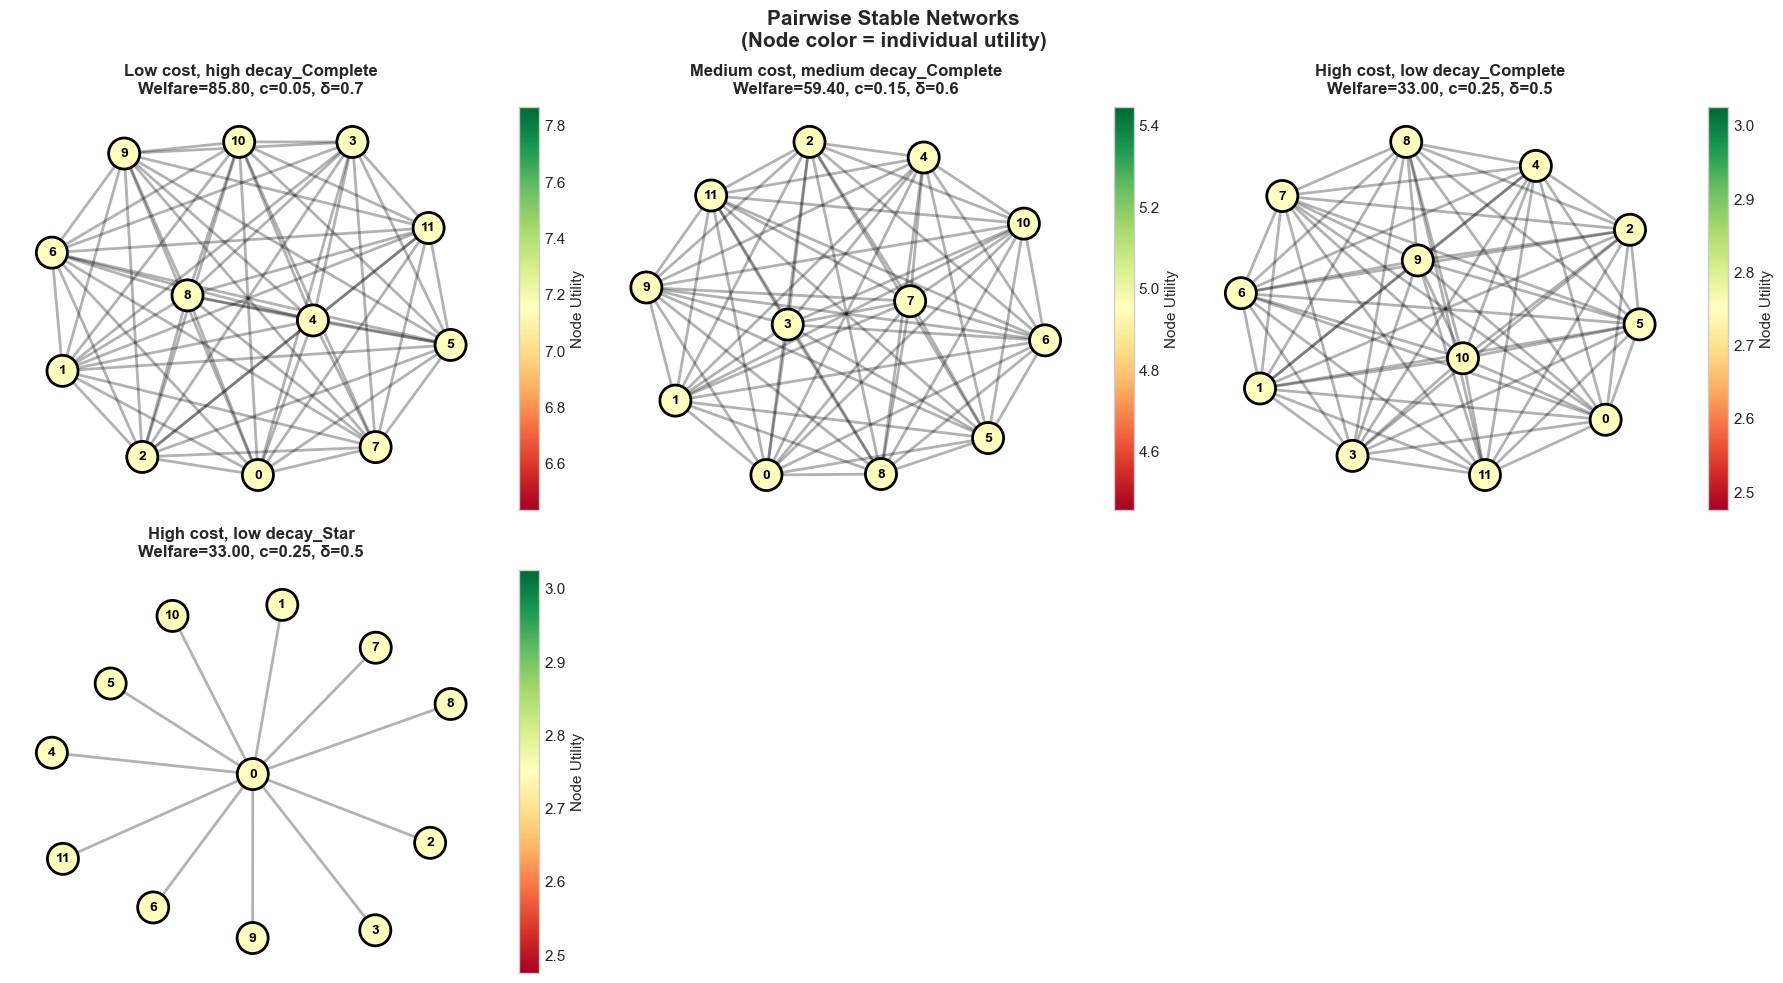


Interpretation:
• Green nodes = high utility (good position)
• Red nodes = low utility (poor position or high costs)
• Star center: pays all costs but gets access to everyone
• Star periphery: low cost, access everyone through center


In [32]:
# Visualize stable networks

if len(stable_networks) > 0:
    n_stable = len(stable_networks)
    n_cols = min(3, n_stable)
    n_rows = (n_stable + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_stable == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, (name, (G, welfare, c, delta)) in enumerate(stable_networks.items()):
        ax = axes[idx]
        
        # Layout
        if 'Star' in name:
            pos = nx.spring_layout(G, k=2, iterations=50)
        else:
            pos = nx.spring_layout(G, k=1, iterations=50)
        
        # Compute utilities for node colors
        utilities = [utility(G, i, c, delta) for i in range(n_agents)]
        
        # Draw
        nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.3, width=2)
        nodes = nx.draw_networkx_nodes(G, pos, ax=ax,
                                       node_size=500,
                                       node_color=utilities,
                                       cmap='RdYlGn',
                                       edgecolors='black',
                                       linewidths=2,
                                       vmin=min(utilities) if utilities else 0,
                                       vmax=max(utilities) if utilities else 1)
        
        # Labels
        labels = {i: f"{i}" for i in range(n_agents)}
        nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=10, font_weight='bold')
        
        ax.set_title(f"{name}\nWelfare={welfare:.2f}, c={c}, δ={delta}",
                    fontsize=12, fontweight='bold', pad=10)
        ax.axis('off')
        
        if utilities:
            plt.colorbar(nodes, ax=ax, label='Node Utility', fraction=0.046)
    
    # Hide empty subplots
    for idx in range(len(stable_networks), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Pairwise Stable Networks\n(Node color = individual utility)',
                fontsize=15, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretation:")
    print("• Green nodes = high utility (good position)")
    print("• Red nodes = low utility (poor position or high costs)")
    print("• Star center: pays all costs but gets access to everyone")
    print("• Star periphery: low cost, access everyone through center")
else:
    print("\nNo stable networks found with tested parameters.")
    print("Try adjusting cost/decay parameters.")


---
# Summary and Key Takeaways

## What We Learned

### 1. Network Formation Mechanisms

**Four fundamental approaches:**

| Model | Mechanism | Generates | Best For |
|-------|-----------|-----------|----------|
| **ER** | Pure random | Poisson degrees, no structure | Null hypothesis |
| **BA** | Preferential attachment | Power-law, hubs | Degree heterogeneity |
| **SBM** | Block structure | Communities | Group structure |
| **Strategic** | Economic incentives | Various (depends on costs) | Policy analysis |

### 2. Scale-Free Networks (Barabási-Albert)

**Key insights:**
- "Rich get richer" → power-law $P(k) \sim k^{-\gamma}$
- Growth + preferential attachment
- $\gamma = 3$ in basic model
- Ultra-small world: $d \sim \log \log n$
- Robust to random failures, vulnerable to attacks

**Financial applications:**
- Banking: Few megabanks, many small banks
- Trade: Hub countries (USA, China)
- Crypto: Bitcoin dominance

### 3. Stochastic Block Models

**Key insights:**
- Community structure from block probabilities
- Assortative: $p_{within} > p_{between}$
- Can generate various structures (core-periphery, hierarchical)
- Good for synthetic data generation

**Extensions:**
- Degree-corrected SBM (heterogeneity + communities)
- Overlapping blocks
- Hierarchical SBM

### 4. Strategic Formation

**Key insights:**
- Agents choose links to maximize utility
- Pairwise stability equilibrium concept
- Stable ≠ Efficient (market failure!)
- Parameters determine structure

**Policy implications:**
- Subsidies/taxes can improve efficiency
- Regulation needed to achieve social optimum
- Design incentives for desired topology

### 5. Synthetic Banking Networks

**Our hybrid approach:**
1. SBM for bank type structure
2. Size heterogeneity (power-law)
3. Size-adjusted connection probabilities
4. Calibration to real properties

**Validation:**
- Degree distribution (power-law tail) ✓
- Clustering coefficient ✓
- Community structure (ARI > 0.5) ✓
- Density (2-5%) ✓

**Use cases:**
- Stress testing with privacy
- Policy counterfactuals
- Contagion simulation
- Network optimization

## Practical Guidelines

### Choosing a Model

**For analysis:**
- Have real data → Fit model, understand mechanisms
- Need null hypothesis → ER model
- Study heterogeneity → BA model
- Study communities → SBM
- Policy design → Strategic model

**For synthesis:**
- Simple benchmark → ER
- Realistic hubs → BA
- Realistic groups → SBM
- **Best for finance:** Hybrid (SBM + heterogeneity)

### Implementation Checklist

**When generating synthetic networks:**

1. **Define requirements**
   - Degree distribution?
   - Community structure?
   - Density target?

2. **Choose base model**
   - Start with SBM if communities matter
   - Add BA if extreme heterogeneity needed

3. **Calibrate parameters**
   - Match real network statistics
   - Use MLE or method of moments

4. **Validate**
   - Degree distribution (KS test)
   - Clustering, path lengths
   - Community detection
   - Centrality distributions

5. **Sensitivity analysis**
   - Test robustness to parameters
   - Multiple realizations
   - Compare with real data

## Connections to Your CBDC Research

### Payment Network Design

**Strategic formation perspective:**
- Banks choose CBDC participation based on costs/benefits
- Network effects: More participants → More valuable
- Design incentives to achieve desired structure
- Avoid concentration in few institutions

**Synthetic networks for testing:**
- Generate realistic payment networks
- Test different CBDC architectures
- Simulate adoption dynamics
- Stress test various configurations

### Financial Stability

**Scale-free implications:**
- Few large institutions dominate (BA model)
- Failure of hub → systemic crisis
- Need macro-prudential policy for hubs
- Monitor concentration over time

**Community structure:**
- Contagion within communities faster
- Cross-community links = shock transmission
- Regulation at community level
- Buffer requirements by network position

### Cross-Border Analysis

**Trade network formation:**
- Strategic: Countries form agreements for gain
- Preferential: Larger economies attract more partners
- Communities: Regional integration (EU, ASEAN)
- Hybrid models capture all aspects

**Capital flow networks:**
- Safe haven countries as hubs (BA)
- Regional communities (SBM)
- Strategic diversification (economic model)

## Next Steps

**Session 6:** Dynamic Network Models
- How networks evolve over time
- Link prediction
- Network evolution mechanisms
- Temporal community detection

**Session 7:** Systemic Risk & Contagion
- DebtRank on generated networks
- Contagion simulation
- Network-based stress testing
- Optimal intervention strategies

**Session 8:** Network VAR
- Dynamic spillovers
- Shock propagation
- Variance decomposition
- Time-varying networks


---
# Exercises

## Exercise 1: BA Parameter Effects (45 min)

Explore how BA parameter $m$ affects network properties:

1. Generate BA networks with $n=500$ and $m \in \{1, 2, 3, 5, 10\}$

2. For each, compute:
   - Degree distribution (fit power law)
   - Clustering coefficient
   - Average path length
   - Diameter
   - Assortativity

3. Plot results vs $m$

4. Explain trends theoretically

**Deliverable:** Plots + theoretical explanation

---

## Exercise 2: SBM Parameter Exploration (1-2 hours)

Study how SBM parameters affect detectability:

1. Fix $n=200$, 4 blocks of 50 nodes each

2. Vary:
   - $p_{within}$ from 0.1 to 0.5
   - $p_{between}$ from 0.01 to 0.1

3. For each combination:
   - Generate 10 networks
   - Apply Louvain detection
   - Compute ARI

4. Create heatmap: ARI vs $(p_{within}, p_{between})$

5. Find transition boundary (ARI = 0.5)

**Deliverable:** Heatmap + detectability analysis

---

## Exercise 3: Real Network Model Selection (2-3 hours)

Fit multiple models to real data:

1. Choose real network (banking, trade, or crypto)

2. Fit models:
   - ER (match density)
   - BA (match average degree)
   - SBM (estimate blocks with Louvain first)
   - Degree-corrected SBM

3. For each model:
   - Generate 100 synthetic networks
   - Compute property distributions

4. Compare with real network:
   - Degree distribution (KS test)
   - Clustering
   - Path length
   - Community structure

5. Which model fits best?

**Deliverable:** Model comparison report

---

## Exercise 4: Banking Network Generator (Advanced, 2-3 hours)

Build complete banking network generator:

1. Design realistic structure:
   - Multiple bank types
   - Size distribution
   - Geographic communities

2. Calibrate to real data:
   - Match empirical degree distribution
   - Match clustering
   - Match density

3. Validation:
   - Generate 50 networks
   - Compare distributions with real
   - Statistical tests

4. Use case:
   - Stress test scenario
   - Policy intervention simulation

**Deliverable:** Calibrated generator + validation

---

## Exercise 5: Strategic Formation Dynamics (Advanced, 2-3 hours)

Simulate network formation process:

1. Start with empty network

2. At each step:
   - Random node pair considers linking
   - Add link if both benefit (utility increases)
   - Delete link if either benefits from deletion

3. Run until no changes (equilibrium)

4. Analyze:
   - Does it reach pairwise stability?
   - How long does convergence take?
   - Path dependence? (different random orders → different equilibria)

5. Vary parameters:
   - Cost $c$
   - Decay $\delta$
   - Number of agents

**Deliverable:** Dynamic formation simulation + equilibrium analysis

---

## Exercise 6: Preferential Attachment Variants (Advanced, 2-3 hours)

Implement and compare PA variants:

1. **Basic BA:** $\Pi(k) \propto k$

2. **With attractiveness:** $\Pi(k) \propto k + A$

3. **Non-linear:** $\Pi(k) \propto k^\alpha$

4. **Fitness model:** $\Pi(k) \propto \eta_i k$

For each variant:
- Generate networks
- Fit power law
- Compare $\gamma$ exponents
- Analyze hub concentration

**Deliverable:** PA variants comparison

---

## Exercise 7: Community Evolution (Challenge, 3-4 hours)

Model dynamic community formation:

1. Start with BA network (no communities)

2. Add community mechanism:
   - Nodes have attributes
   - Homophily: Similar nodes more likely to connect
   - Heterophily: Dissimilar nodes connect (weak ties)

3. Simulate evolution:
   - Add nodes over time
   - PA + homophily combined

4. Track:
   - Community structure emergence
   - Modularity over time
   - Cross-community bridges

5. Compare with:
   - Pure BA (no communities)
   - Pure SBM (communities from start)

**Deliverable:** Dynamic community emergence analysis

---

## Exercise 8: CBDC Network Design (Challenge, 3-4 hours)

Design optimal CBDC network structure:

1. Define objectives:
   - Decentralization (low concentration)
   - Efficiency (short paths)
   - Resilience (robustness)
   - Fairness (equal access)

2. Generate candidate networks:
   - Star (central bank hub)
   - Mesh (peer-to-peer)
   - Hybrid (tiered)
   - Generated by strategic model

3. Evaluate each on objectives:
   - Compute metrics
   - Stress test
   - Fairness analysis

4. Multi-objective optimization:
   - Pareto frontier
   - Trade-offs

5. Policy recommendation

**Deliverable:** CBDC network design proposal


---
# References

## Scale-Free Networks

1. **Barabási, A.L., & Albert, R.** (1999). Emergence of scaling in random networks. *Science*, 286(5439), 509-512.
   - **Original preferential attachment paper**

2. **Albert, R., & Barabási, A.L.** (2002). Statistical mechanics of complex networks. *Reviews of Modern Physics*, 74(1), 47.
   - Comprehensive review

3. **Newman, M.E.J.** (2005). Power laws, Pareto distributions and Zipf's law. *Contemporary Physics*, 46(5), 323-351.
   - Power law detection and fitting

## Stochastic Block Models

4. **Holland, P.W., Laskey, K.B., & Leinhardt, S.** (1983). Stochastic blockmodels: First steps. *Social Networks*, 5(2), 109-137.
   - **Original SBM paper**

5. **Karrer, B., & Newman, M.E.J.** (2011). Stochastic blockmodels and community structure in networks. *Physical Review E*, 83(1), 016107.
   - Degree-corrected SBM

6. **Abbe, E.** (2017). Community detection and stochastic block models. *Foundations and Trends in Communications and Information Theory*, 14(1-2), 1-162.
   - Modern comprehensive treatment

## Strategic Network Formation

7. **Jackson, M.O., & Wolinsky, A.** (1996). A strategic model of social and economic networks. *Journal of Economic Theory*, 71(1), 44-74.
   - **Foundational paper** on strategic formation

8. **Jackson, M.O.** (2008). *Social and Economic Networks*. Princeton University Press.
   - **Textbook** covering formation, stability, efficiency

9. **Goyal, S.** (2007). *Connections: An Introduction to the Economics of Networks*. Princeton University Press.
   - Economic network theory textbook

## Financial Networks

10. **Boss, M., et al.** (2004). Network topology of the interbank market. *Quantitative Finance*, 4(6), 677-684.
    - Empirical banking network structure

11. **Craig, B., & Von Peter, G.** (2014). Interbank tiering and money center banks. *Journal of Financial Intermediation*, 23(3), 322-347.
    - Core-periphery structure in banking

12. **Hüser, A.C.** (2015). Too interconnected to fail: A survey of the interbank networks literature. *SAFE Working Paper*, 91.
    - Banking network survey

13. **Anand, K., et al.** (2018). The missing links: A global study on uncovering financial network structures from partial data. *Journal of Financial Stability*, 35, 107-119.
    - Network reconstruction

## Synthetic Networks

14. **Finger, K., Fricke, D., & Lux, T.** (2013). Network analysis of the e-MID overnight money market. *Journal of Banking & Finance*, 37(7), 2925-2936.
    - Synthetic interbank networks

15. **Gandy, A., & Veraart, L.A.** (2017). A Bayesian methodology for systemic risk assessment. *Management Science*, 63(4), 1047-1062.
    - Bayesian network generation

## Cryptocurrency Networks

16. **Makarov, I., & Schoar, A.** (2020). Trading and arbitrage in cryptocurrency markets. *Journal of Financial Economics*, 135(2), 293-319.

17. **Kondor, D., et al.** (2014). Do the rich get richer? An empirical analysis of the Bitcoin transaction network. *PloS ONE*, 9(2), e86197.
    - BA model in Bitcoin

## Methodology

18. **Clauset, A., Shalizi, C.R., & Newman, M.E.J.** (2009). Power-law distributions in empirical data. *SIAM Review*, 51(4), 661-703.
    - **Essential** for fitting power laws

19. **Peixoto, T.P.** (2019). Bayesian stochastic blockmodeling. In *Advances in Network Clustering and Blockmodeling*. Wiley.
    - Modern SBM inference

20. **Snijders, T.A., et al.** (2010). Introduction to stochastic actor-based models for network dynamics. *Social Networks*, 32(1), 44-60.
    - Dynamic formation models

## Software

- **NetworkX:** https://networkx.org/
  - Generators: `barabasi_albert_graph`, `stochastic_block_model`
  
- **graph-tool:** https://graph-tool.skewed.de/
  - Fast SBM inference
  
- **igraph:** https://igraph.org/
  - BA, SBM, ER generators
  
- **powerlaw:** https://github.com/jeffalstott/powerlaw
  - Power law fitting and testing

## CBDC & Payment Networks

- **BIS Innovation Hub:** https://www.bis.org/about/bisih.htm
  - CBDC network architectures
  
- **Project Ubin (Singapore):** Various reports on network design
  
- **Project Jasper (Canada):** DLT-based payment system research


In [ ]:
# Session complete!
print("="*70)
print("SESSION 5 COMPLETE: NETWORK FORMATION MODELS")
print("="*70)
print("\nYou've learned:")
print("  ✓ Preferential attachment and scale-free networks")
print("  ✓ Stochastic block models for communities")
print("  ✓ Strategic network formation")
print("  ✓ Hybrid models for realistic synthesis")
print("  ✓ Banking network generation and validation")
print("\nNext session: Dynamic Networks")
print("  • How networks evolve over time")
print("  • Link prediction")
print("  • Temporal community detection")
print("  • Network dynamics and adaptation")
print("="*70)
